In [1]:
import pyspark
from pyspark import SparkContext
import imageio
import os
import numpy as np
from scipy.ndimage import median_filter

In [2]:
def readImg(path):
    img = imageio.imread(path)
    im = np.array(img,dtype='uint8')
    return im

def writeImg(path,buf):
    imageio.imwrite(path,buf)

In [3]:
def part_median_filter(local_data):
    part_id = local_data[0]
    first   = local_data[1]
    end     = local_data[2]
    buf     = local_data[3]
    nx=buf.shape[0]
    ny=buf.shape[1]
    
    filly = np.zeros(shape=(nx, 1, 3)) 

    buf = np.concatenate([buf, filly], axis=1)
    ########################################
    #
    # CREATE NEW BUF WITH MEDIAN FILTER SOLUTION
    #
    new_buf = np.zeros(shape=(nx - 2, ny, 3), dtype='uint8') # -2 pour effets de bords
    #print(f"new_buf size {new_buf.shape}")
    
    ##########################################
    #
    # TODO COMPUTE MEDIAN FILTER
    #
    for i in range(new_buf.shape[0]):
        for j in range(0, new_buf.shape[1]):
            neigh = np.array([buf[i,j-1], buf[i,j], buf[i,j+1], buf[i+1,j-1], buf[i+1,j],
                              buf[i+1,j+1], buf[i+2,j-1], buf[i+2,j], buf[i+2,j+1]])
            new_buf[i, j, :] = np.median(neigh, axis=0)
    
    ##########################################
    #
    # RETURN LOCAL IMAGE PART
    #
    return part_id, new_buf

In [4]:
def main(n):
    data_dir = ''
    file = os.path.join(data_dir,'lena_noisy.jpg')
    img_buf = readImg(file)
    #print('SHAPE',img_buf.shape)
    #print('IMG\n',img_buf)
    nx=img_buf.shape[0]
    ny=img_buf.shape[1]
    
    ###########################################################################
    #
    # SPLT IMAGES IN NB_PARTITIONS PARTS
    nb_partitions = n
    #print("NB PARTITIONS : ",nb_partitions)
    data=[]
    begin=0
    block_size=nx/nb_partitions
    fill = np.zeros((1, ny, 3))
    if nb_partitions > 1:
        for ip in range(nb_partitions):
            begin = int(max(ip * block_size - 1, 0))
            end = int(min((ip+1) * block_size + 1, nx))
            if (ip == 0):
                filled = np.concatenate([fill, img_buf[begin:end, :, :]])
                data.append([ip,begin,end,filled])
            elif (ip == (nb_partitions - 1)):
                filled = np.concatenate([img_buf[begin:end, :, :], fill])
                data.append([ip,begin,end,filled])
            else: 
                data.append([ip, begin, end, img_buf[begin:end, :, :]])
    else:
        filled = np.concatenate([fill, img_buf, fill])
        data.append([1, begin, nx, filled])

    """for i in range(nb_partitions):
        print(f"Partition {i} shape {data[i][3].shape}")"""
    ###########################################################################
    #
    # CREATE SPARKCONTEXT
    data_rdd = sc.parallelize(data, nb_partitions)

    
    
    ###########################################################################
    #
    # PARALLEL MEDIAN FILTER COMPUTATION
    result_rdd = data_rdd.map(part_median_filter)
    result_data = result_rdd.collect() # list of 8
    
    ###########################################################################
    #
    # COMPUTE NEW IMAGE RESULTS FROM RESULT RDD
    ids = []
    arrays = []
    for i, d in result_data:
        ids.append(int(i))
        arrays.append(d)
        
    ids = np.asarray(ids)
    arrays = np.asarray(arrays)
    order = np.argsort(ids)
    
    ids = ids[order]
    arrays = arrays[order]
    
    new_img_buf = np.concatenate(arrays)
    print(f"Final shape : {new_img_buf.shape}")
    
    print('CREATE NEW PICTURE FILE')
    filter_file = os.path.join(data_dir,'lena_filter.jpg')
    writeImg(filter_file, new_img_buf)

In [5]:
import time


sc = SparkContext()
main(1)

n_chunks = [1, 2, 4, 8]
times = []
for i in [1, 2, 4, 8]:
    start_t = time.time()
    main(i)
    times.append(time.time() - start_t)
print(times)

2022-02-19 15:59:06,705 WARN util.Utils: Your hostname, HPCAI10 resolves to a loopback address: 127.0.1.1; using 192.168.1.85 instead (on interface wifi0)
2022-02-19 15:59:06,706 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Final shape : (128, 128, 3)
CREATE NEW PICTURE FILE
Final shape : (128, 128, 3)
CREATE NEW PICTURE FILE
Final shape : (128, 128, 3)
CREATE NEW PICTURE FILE
Final shape : (128, 128, 3)
CREATE NEW PICTURE FILE
Final shape : (128, 128, 3)
CREATE NEW PICTURE FILE
[0.6376335620880127, 0.3685026168823242, 0.2895369529724121, 0.3275258541107178]


Text(0.5, 1.0, 'Spark compute time as a function of n_chunks')

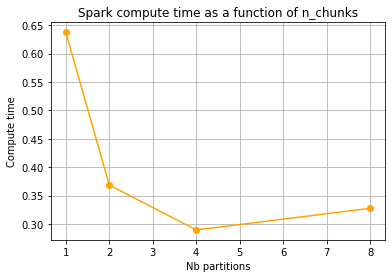

In [9]:
import matplotlib.pyplot as plt
n_chunks = [1, 2, 4, 8]
plt.plot(n_chunks, times, label="Spark", marker="o", color="orange")
plt.grid()
plt.xlabel("Nb partitions")
plt.ylabel("Compute time")
plt.title("Spark compute time as a function of n_chunks")
#plt.savefig("spark.png")